# LAB 5.4 - Video Classification

The labs require a `tensorflow` version lower than the default one used in Google Colab. Run the following cell to downgrade TensorFlow accordingly.

In [ ]:
import os
def downgrade_tf_version():
    os.system("!yes | pip uninstall -y tensorflow")
    os.system("!yes | pip install tensorflow==2.12.0")
    os.kill(os.getpid(), 9)
downgrade_tf_version()

In [1]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False); init.get_weblink() 

In [ ]:
from local.lib.rlxmoocapi import submit, session
import inspect
student = session.LoginSequence(endpoint=init.endpoint, course_id=init.course_id, lab_id="L05.04", varname="student")

In [ ]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
print("TF version: ", tf.__version__)
print("Hub version: ", hub.__version__)

## Context:

This lab is intended to implement a DL architecture for video classifcation. The dataset is a subset of the [UCF50 action recognition dataset](https://www.crcv.ucf.edu/data/UCF50.php); only two classes are going to be used: diving and breaststroke (face down swimming stroke).

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import math

### Let's get the data

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://drive.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=1gLhwdtjBUA6_7GIXygaEdKrtbcgsUQqt' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1gLhwdtjBUA6_7GIXygaEdKrtbcgsUQqt" -O UCF50_subset.tar.gz && rm -rf /tmp/cookies.txt

In [4]:
!tar -xf UCF50_subset.tar.gz

In [31]:
# Utilities to open video files using CV2
import cv2
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

def load_video(path, max_frames=0, resize=(224, 224)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames) / 255.0


In [32]:
import os
videos = []
class_video = []
for dire in os.listdir('UCF50_subset'):
    for files in os.listdir('UCF50_subset/'+dire):
        videos.append(load_video('UCF50_subset/'+dire+'/'+files,max_frames=30))
        class_video.append(dire)
videos = np.array(videos)

In [33]:
videos.shape

## Task 1.

Create a model to classify the videos in the dataset described above. The model must be based on a VGG16 convolutional architecture (without the last three dense layers), and then on top of the VGG16 add the following layers:

- Dense
- LSTM
- Dropout
- Dense
- Dropout
- Output layer

All the layers of the VGG component must be set as non trainable. Once defined you must get the following architecture for the given parameters:

**Note**: neurons is a list that contains the number of neurons (cells in the case of LSTM) for the Dense and recurrent layers in the arquitecture, in the same order as they are added to the model architecture.

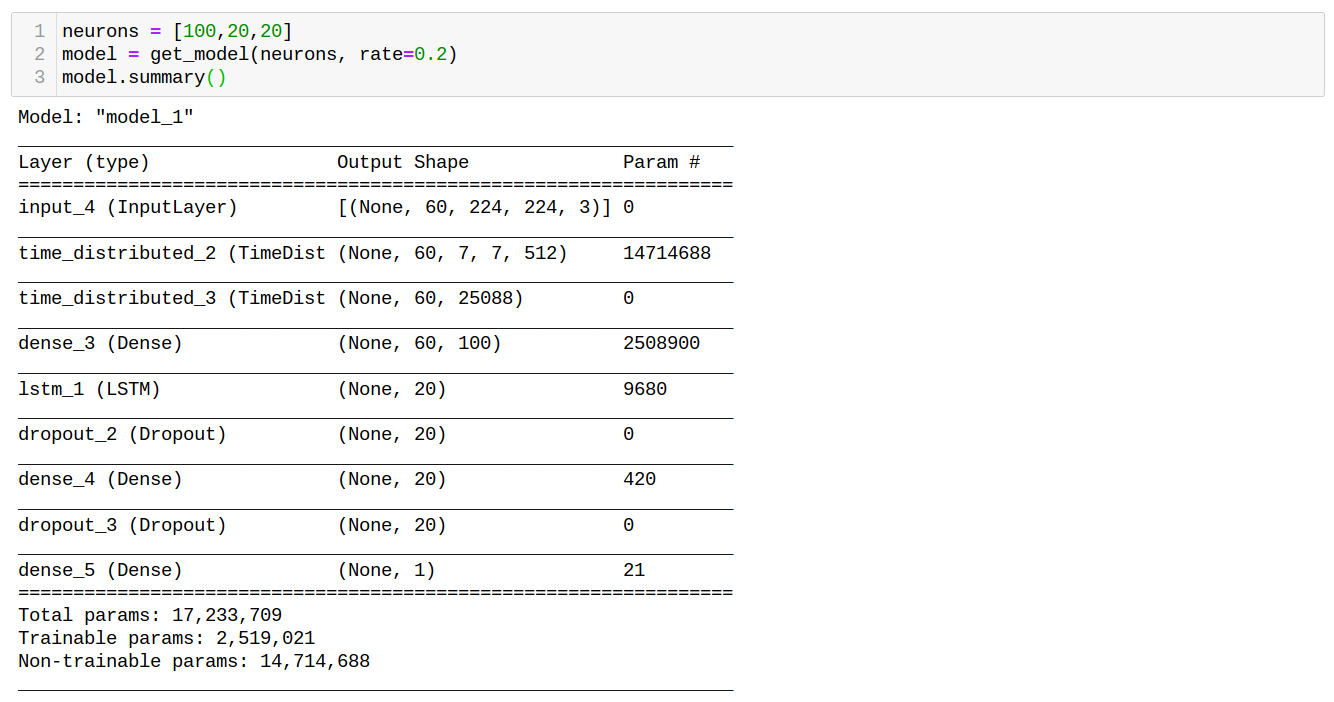

In [34]:

from IPython.display import Image
Image("local/imgs/VideoClassifyArch.png")


In [ ]:
def get_model():
    model = ...
    
    return model

**Submit your solution:**

In [7]:
student.submit_task(namespace=globals(), task_id='T1');

### Let's test the model: 

**Warning**: Run this part only if you have already passed Tasks 1.

In [8]:
neurons = [100,20,20]
model = get_model(neurons, rate=0.2)
model.predict(videos[0:2,:])

In [9]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
le = preprocessing.LabelEncoder()
le.fit(np.unique(class_video))
Y=le.transform(class_video)

In [11]:
X_tr, X_te, y_tr, y_te = train_test_split(videos, Y, test_size=0.2, random_state=2018)

In [12]:
model.fit(X_tr,y_tr,epochs=10, batch_size=2)

In [17]:
from sklearn.metrics import classification_report
y_est = model.predict(X_te,batch_size=2)
print(classification_report(y_te, np.round(y_est), target_names=np.unique(class_video)))